In [1]:
using StatsPlots, Plots, Distributions, Random, RCall

### 1. Use the Metropolis-Hastings sampler to generate a sample from a Rayleigh distribution

In [119]:
MH_algorithm = function(init = 5, size = 1000 ,burnin = 100)
    f(x,σ² =3)= x/σ² * exp((-x^2)/(2*σ²))
    data = []
    x_j = init
    for i in 1:size+burnin 

        x_star = rand(Gamma(x_j,1))

        accept_prob = min(1, f(x_star)/f(x_j) *
        pdf(Gamma(x_star, 1),x_j)/pdf(Gamma(x_j, 1),x_star)  ) 


        flag = rand(Uniform(0,1))
        if flag < accept_prob
            x_jnew = x_star
        else
            x_jnew = x_j
        end
        
        data=[data; x_jnew]
        x_j = x_jnew
    end
    return data[burnin+1:end]
end

#8 (generic function with 4 methods)

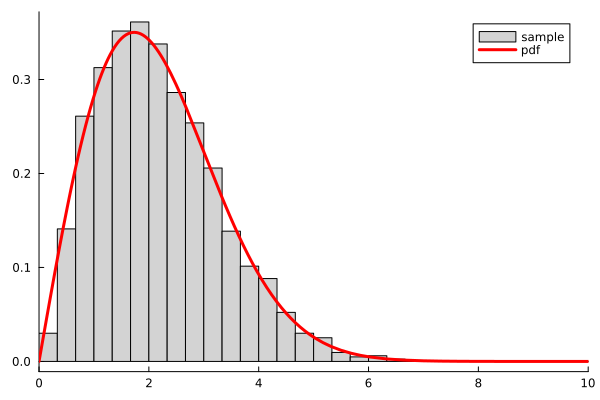

In [120]:
f(x,σ² =3)= x/σ² * exp((-x^2)/(2*σ²))
histogram(MH_algorithm(5,5000,2000), normalize=:pdf, 
bins=range(0, 10, length=31), legend=true, color=:gray, label="sample")
plot!(f,xlim=[0,10], lw=3, color=:red, label="pdf")

### 2. Use the Gibbs sampler to generate a chain with target joint density f (x, y). Use the Gelman-Rubin convergence method to monitor the convergence of the chain. Repeat the analysis in the Example.


In [110]:
struct pair
    x
    y
end
function Gibb_sampling(size, n, a, b, init=[5,0.5], burn_in=100)  

    function X_condition_on_y(n,y) 
        return Binomial(n , y)
    end

    function Y_condition_on_x(n,a,b,x) 
        return Beta(x+a , n-x+b)
    end
   
    x = ones(1+burn_in+size)*init[1]
    y = ones(1+burn_in+size)*init[2]

    for i = 2:burn_in+size+1
        x[i] = rand(X_condition_on_y(n,y[i-1])) 
        y[i] = rand(Y_condition_on_x(n,a,b,x[i])) 
    end

    return pair(x[1+burn_in+1:end], y[1+burn_in+1:end])

end

Gibb_sampling (generic function with 3 methods)

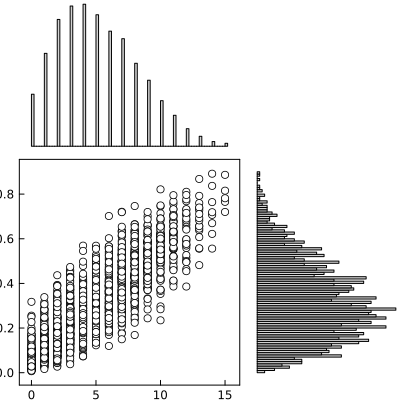

In [111]:
num = 2000
data = Gibb_sampling(num, 16, 2, 4)
x = data.x
y = data.y    

layout = @layout [a{0.6w,0.4h} _
                  b{0.6w,0.6h} c{0.4w, 0.6h}]

default(fillcolor=:lightgrey, markercolor=:white, grid=false, legend=false)
plot(layout=layout, link=:both, size=(400, 400),  margin=-10Plots.pt)
scatter!(x,y, subplot=2, framestyle =:box)
histogram!([x y], subplot=[1 3], orientation=[:v :h], 
framestyle=:none, bins=min(num, 100), normalize=true)

In [112]:
function Gelman_Rubin(psi) 
    k = size(psi)[1]
    n = size(psi)[2]
    psi_means = mean(psi, dims=2)
    B = n * var(psi_means)
    psi_w = var(psi, dims=2) * (n-1)/n
    W = mean(psi_w)   
    v_hat = W*(n-1)/n + (B/n)      
    r_hat = v_hat / W 
    return  r_hat
end

Gelman_Rubin (generic function with 1 method)

In [113]:
function mcmclist_x(init_args_pair , size = 1000, n = 20, a = 2, b = 4)
    data = []
    data = reshape([],0,size)
    for i in init_args_pair
        data_new = Gibb_sampling(size, n, a, b, i).x'
        data = vcat(data,data_new)
    end
    return data
end
function mcmclist_y(init_args_pair , size = 1000, n = 20, a = 2, b = 4)
    data = []
    data = reshape([],0,size)
    for i in init_args_pair
        data_new = Gibb_sampling(size, n, a, b, i).y'
        data = vcat(data,data_new)
    end
    return data
end

mcmclist_y (generic function with 5 methods)

In [117]:
Gelman_Rubin(mcmclist_x( [[0,0],[1,0.2],[2,0.4],[4,0.6],[8,0.8],[16,1]] )) 

1.0100443430833996

In [118]:
Gelman_Rubin(mcmclist_y( [[0,0],[1,0.2],[2,0.4],[4,0.6],[8,0.8],[16,1]] )) 

1.0196212958691533

The G_R statistic are less than 1.1, so we can state that chains are converge.